In [117]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time

In [118]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    TODO: Später Orientierungswinkel rein (und Winkel in der Messfunktion beachten)
    """  
    x, y, vx, vy = state

    # Update position with current velocity
    new_x = x + vx * dt
    new_y = y + vy * dt

    # Speed stays constant (no acceleration yet)
    new_vx = vx
    new_vy = vy

    return np.array([new_x, new_y, new_vx, new_vy])

In [119]:
beacon0_pos = np.array([-30, 0])
beacon1_pos = np.array([30, 0])

def h_x(state):
    """
    Messfunktion.
    Bildet den Zustandsraum (Position und Geschwindigkeit des Schiffs)
    auf den Messraum ab (Winkel von den Funktürmen), wobei definiert als:
    - Norden als 0°, 
    - Osten als 270°,
    - Süden als 180°,
    - Westen als 90°.
    """
    x, y, _, _ = state

    # Calculate angle (from the ship) to each beacon (converse from radians ->  angles)
    angle0 = np.arctan2(y - beacon0_pos[1], x - beacon0_pos[0]) * 180 / np.pi
    angle1 = np.arctan2(y - beacon1_pos[1], x - beacon1_pos[0]) * 180 / np.pi

    # Adjust angles to defined orientation (also implement orientation angle later)
    angle0 = (angle0 + 270) % 360
    angle1 = (angle1 + 270) % 360

    return np.array([angle0, angle1])

In [126]:
# Lese Ground Truth und (verrauschte) Messung aus Datei

file_path = 'UKF-30-01.2024_log.csv'


def parse_line(line):
    # Split the line using tab as the delimiter
    parts = line.strip().split('\t')

    # Extract relevant data at indices 1, 5, and 10
    timestamp = int(parts[1])
    angle_noisy = float(parts[5])
    y_gt = float(parts[10])
    x_gt = float(parts[11])

    return timestamp, angle_noisy, y_gt, x_gt


# Contains all ground truth states: <x, y, velocity_x, velocity_y>
states = []
# Contains measurement data: <deltaT, np.array([angle_beacon0, angle_beacon1])>
zs = []

# Open and read the CSV file
with open(file_path, 'r') as file:
    lines = file.readlines()

# script has to keep track of previous line 
# STARTS WITH BEACHON ID=0 !! (make sure log data is formatted accordingly)
prev_line_timestamp = None
prev_line_y_value = None
prev_line_x_value = None
beacon0_angle = None

# Loop through the lines and create 'state' arrays
for i, line in enumerate(lines):
    timestamp, angle_noisy, y_gt, x_gt = parse_line(line)
    # SYNCHONOUS IMPLEMENTATION. Works only for beacons with same frequency
    is_beacon1_line = i % 2 == 1 # every other line is beacon1 line
    if is_beacon1_line:
        # can't determine velocity in first loop
        if prev_line_timestamp is None:
            vel_x = 0
            vel_y = 0
        else:
            time_diff_seconds = (timestamp - prev_line_timestamp) / 1000.0
            vel_x = (x_gt - prev_line_x_value) * time_diff_seconds
            vel_y = (y_gt - prev_line_y_value) * time_diff_seconds

        # prev_y_value is used since this is absolute y at timestamp
        # results in slightly distorted second beacon angle since timestamp and y value differ slightly
        states.append(
            np.array([prev_line_x_value, prev_line_y_value, vel_x, vel_y]))
        zs.append([time_diff_seconds, np.array([beacon0_angle, angle_noisy])])
    else:
        beacon0_angle = angle_noisy

    # Update previous values for the next iteration
    prev_line_timestamp = timestamp
    prev_line_y_value = y_gt
    prev_line_x_value = x_gt


# Print the resulting 'state' array
# for state in states:
    # print(state)
# for zustand in zs:
#     print(zustand)

In [125]:
# UKF
std_0 = 1.01
std_1 = 1.01
dT = 0.1  # 0.1 sec


sigmas = MerweScaledSigmaPoints(4, alpha = 0.1, beta = 2.0, kappa = 1.0)

ukf = UKF(dim_x = 4, dim_z = 2, fx = f_x, hx = h_x, dt = dT, points = sigmas)

# FRAGE: wieso wird hier nicht verrauschte Daten genommen (zs) ?
ukf.x = states[0].copy()
ukf.R = np.diag([std_0 ** 2, std_1 ** 2])
# TODO: muss hier dT irgendwie angepasst werden pro Zeitschritt? 
# Oder generiert das nur random white noise? 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt = dT, var = 0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt = dT, var = 0.02)
# print(ukf.R)
# print(ukf.Q)

In [124]:
# bereche position mit UKF

uxs = []

temp = ukf.x.copy()

for z in zs:

    # ukf.predict(dT)
    ukf.predict(z[0])
    # ukf.update(z)
    ukf.update(z[1])

    """
    # update die Geschwindigkeit, basierend auf der vorherigen Position
    ukf.x[2] = (ukf.x[0] - temp[0]) * dT # ukf.dT gibts nicht?
    ukf.x[3] = (ukf.x[1] - temp[1]) * dT
    temp = ukf.x.copy()
    print(temp)
    #"""

    uxs.append(ukf.x.copy())
    # print(ukf.x.copy())

uxs = np.array(uxs)

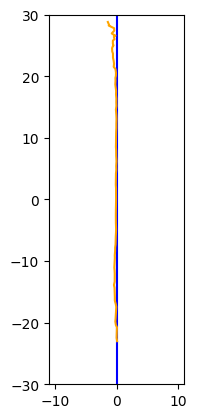

In [123]:
# visualisiere gefilterten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]

fig, ax = plt.subplots()
plt.xlim(-11, 11)
plt.ylim(-30, 30)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')
plt.plot(ux_val, uy_val, color = 'orange')

#plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
#plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')

plt.show()